Just to preface this- I didn't take the time to clean any of the code and know it is fairly messy (sorry!). I did write some comments for each cell to help with getting through it!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#These are some imports that I just tend to copy and paste when I'm doing classification... not everything here is used.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, precision_score, recall_score, log_loss, mean_squared_error, brier_score_loss
import xgboost
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2025/Conferences.csv
/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/WSecondaryTourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2025/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-20

In [2]:
#Read in tournament, regular season, and seed files for both men & women
#"Set" denotes whether the data is from the regular season or tournament (1 = tournament, 0 = regular season)
#Changed seed to only denote the numerical seed value

men_tournament = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyDetailedResults.csv")
men_tournament.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
men_tournament["set"] = 1
men_seeds = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeeds.csv")
men_seeds["Seed"] = men_seeds["Seed"].apply(lambda x: int(x[1:3]))
men_regular = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv")
men_regular.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
men_regular["set"] = 0

women_tournament = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv")
women_tournament.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
women_tournament["set"] = 1
women_seeds = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySeeds.csv")
women_seeds["Seed"] = women_seeds["Seed"].apply(lambda x: int(x[1:3]))
women_regular = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonDetailedResults.csv")
women_regular.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
women_regular["set"] = 0

#Combine regular season data and tournament data into one dataframe 
#Add feature for gender to try to quantify some differences in efficiency, playstyle, etc... (1 = men, 0 = women)

men_box = pd.concat([men_tournament, men_regular], ignore_index=True)
men_box["gender"] = 1
women_box = pd.concat([women_tournament, women_regular], ignore_index=True)
women_box["gender"] = 0

men_women_box = pd.concat([men_box, women_box], ignore_index=True)
men_women_seeds = pd.concat([men_seeds, women_seeds], ignore_index=True)

In [3]:
#Rename the features for the winning team as "TeamA" and "TeamB" for the losing team... also flip the labels to create double the data (each game can be seen from 
#two perspectives... the winner and the loser)

w_df = men_women_box.loc[:, ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'set', 'gender']]
w_df.columns = [
    'Season', 'DayNum', 
    'ATeamID', 'AScore', 'BTeamID', 'BScore', 
    'AFGM', 'AFGA', 'AFGM3', 'AFGA3', 'AFTM', 'AFTA', 'AOR', 'ADR', 'AAst', 'ATO', 'AStl', 'ABlk', 'APF', 
    'BFGM', 'BFGA', 'BFGM3', 'BFGA3', 'BFTM', 'BFTA', 'BOR', 'BDR', 'BAst', 'BTO', 'BStl', 'BBlk', 'BPF', 
    'Set', 'Gender'
]

l_df = men_women_box.loc[:, ['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'LFGM',
       'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO',
       'LStl', 'LBlk', 'LPF', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA',
       'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'set', 'gender']]
l_df.columns = [
    'Season', 'DayNum', 
    'ATeamID', 'AScore', 'BTeamID', 'BScore', 
    'AFGM', 'AFGA', 'AFGM3', 'AFGA3', 'AFTM', 'AFTA', 'AOR', 'ADR', 'AAst', 'ATO', 'AStl', 'ABlk', 'APF', 
    'BFGM', 'BFGA', 'BFGM3', 'BFGA3', 'BFTM', 'BFTA', 'BOR', 'BDR', 'BAst', 'BTO', 'BStl', 'BBlk', 'BPF', 
    'Set', 'Gender'
]

#Concat new dataframes/columns
#Create a column to denote the outcome of a game for both TeamA and TeamB

all_box = pd.concat([w_df, l_df], axis=0)
all_box['AWin'] = (all_box['AScore'] > all_box['BScore']).astype(int)
all_box['ALoss'] = (all_box['AScore'] < all_box['BScore']).astype(int)
all_box['BWin'] = (all_box['AScore'] < all_box['BScore']).astype(int)
all_box['BLoss'] = (all_box['AScore'] > all_box['BScore']).astype(int)

In [4]:
#The start of creating features for both TeamA and TeamB
#Group by Season and the teamID to calculate the total for a specified column

#A features
all_box['AWins'] = all_box.groupby(['Season', 'ATeamID'])['AWin'].transform('sum')
all_box['ALosses'] = all_box.groupby(['Season', 'ATeamID'])['ALoss'].transform('sum')
all_box['AGames'] = all_box["AWins"] + all_box["ALosses"]
all_box['ATotalPts'] = all_box.groupby(['Season', 'ATeamID'])['AScore'].transform('sum')
all_box["ATotalFGM"] = all_box.groupby(['Season', 'ATeamID'])['AFGM'].transform('sum')
all_box["ATotalFGA"] = all_box.groupby(['Season', 'ATeamID'])['AFGA'].transform('sum')
all_box["ATotal3PM"] = all_box.groupby(['Season', 'ATeamID'])['AFGM3'].transform('sum')
all_box["ATotal3PA"] = all_box.groupby(['Season', 'ATeamID'])['AFGA3'].transform('sum')
all_box["ATotalFTM"] = all_box.groupby(['Season', 'ATeamID'])['AFTM'].transform('sum')
all_box["ATotalFTA"] = all_box.groupby(['Season', 'ATeamID'])['AFTA'].transform('sum')
all_box["ATotalOR"] = all_box.groupby(['Season', 'ATeamID'])['AOR'].transform('sum')
all_box["ATotalDR"] = all_box.groupby(['Season', 'ATeamID'])['ADR'].transform('sum')
all_box["ATotalAst"] = all_box.groupby(['Season', 'ATeamID'])['AAst'].transform('sum')
all_box["ATotalTO"] = all_box.groupby(['Season', 'ATeamID'])['ATO'].transform('sum')
all_box["ATotalStl"] = all_box.groupby(['Season', 'ATeamID'])['AStl'].transform('sum')
all_box["ATotalBlk"] = all_box.groupby(['Season', 'ATeamID'])['ABlk'].transform('sum')
all_box["ATotalPf"] = all_box.groupby(['Season', 'ATeamID'])['APF'].transform('sum')

#B features
all_box['BWins'] = all_box.groupby(['Season', 'BTeamID'])['BWin'].transform('sum')
all_box['BLosses'] = all_box.groupby(['Season', 'BTeamID'])['BLoss'].transform('sum')
all_box['BGames'] = all_box["BWins"] + all_box["BLosses"]
all_box['BTotalPts'] = all_box.groupby(['Season', 'BTeamID'])['BScore'].transform('sum')
all_box["BTotalFGM"] = all_box.groupby(['Season', 'BTeamID'])['BFGM'].transform('sum')
all_box["BTotalFGA"] = all_box.groupby(['Season', 'BTeamID'])['BFGA'].transform('sum')
all_box["BTotal3PM"] = all_box.groupby(['Season', 'BTeamID'])['BFGM3'].transform('sum')
all_box["BTotal3PA"] = all_box.groupby(['Season', 'BTeamID'])['BFGA3'].transform('sum')
all_box["BTotalFTM"] = all_box.groupby(['Season', 'BTeamID'])['BFTM'].transform('sum')
all_box["BTotalFTA"] = all_box.groupby(['Season', 'BTeamID'])['BFTA'].transform('sum')
all_box["BTotalOR"] = all_box.groupby(['Season', 'BTeamID'])['BOR'].transform('sum')
all_box["BTotalDR"] = all_box.groupby(['Season', 'BTeamID'])['BDR'].transform('sum')
all_box["BTotalAst"] = all_box.groupby(['Season', 'BTeamID'])['BAst'].transform('sum')
all_box["BTotalTO"] = all_box.groupby(['Season', 'BTeamID'])['BTO'].transform('sum')
all_box["BTotalStl"] = all_box.groupby(['Season', 'BTeamID'])['BStl'].transform('sum')
all_box["BTotalBlk"] = all_box.groupby(['Season', 'BTeamID'])['BBlk'].transform('sum')
all_box["BTotalPf"] = all_box.groupby(['Season', 'BTeamID'])['BPF'].transform('sum')

In [5]:
#More total features
#Group by Season and the teamID to calculate the total for a specified column
#These columns are for the opponent of a specified team... can be used to identify how well a team did against an opponent relative to their average performance

all_box['AOppWins'] = all_box.groupby(['Season', 'BTeamID'])['BWin'].transform('sum')
all_box['AOppLosses'] = all_box.groupby(['Season', 'BTeamID'])['BLoss'].transform('sum')
all_box['BOppWins'] = all_box.groupby(['Season', 'BTeamID'])['AWin'].transform('sum')
all_box['BOppLosses'] = all_box.groupby(['Season', 'BTeamID'])['ALoss'].transform('sum')
all_box['AOppGames'] = all_box["BOppWins"] + all_box["BOppLosses"]
all_box['BOppGames'] = all_box["BOppWins"] + all_box["BOppLosses"]
#A Opponent features
all_box['AOppPts'] = all_box.groupby(['Season', 'ATeamID'])['BScore'].transform('sum')
all_box["AOppFGM"] = all_box.groupby(['Season', 'ATeamID'])['BFGM'].transform('sum')
all_box["AOppFGA"] = all_box.groupby(['Season', 'ATeamID'])['BFGA'].transform('sum')
all_box["AOpp3PM"] = all_box.groupby(['Season', 'ATeamID'])['BFGM3'].transform('sum')
all_box["AOpp3PA"] = all_box.groupby(['Season', 'ATeamID'])['BFGA3'].transform('sum')
all_box["AOppFTM"] = all_box.groupby(['Season', 'ATeamID'])['BFTM'].transform('sum')
all_box["AOppFTA"] = all_box.groupby(['Season', 'ATeamID'])['BFTA'].transform('sum')
all_box["AOppOR"] = all_box.groupby(['Season', 'ATeamID'])['BOR'].transform('sum')
all_box["AOppDR"] = all_box.groupby(['Season', 'ATeamID'])['BDR'].transform('sum')
all_box["AOppAst"] = all_box.groupby(['Season', 'ATeamID'])['BAst'].transform('sum')
all_box["AOppTO"] = all_box.groupby(['Season', 'ATeamID'])['BTO'].transform('sum')
all_box["AOppStl"] = all_box.groupby(['Season', 'ATeamID'])['BStl'].transform('sum')
all_box["AOppBlk"] = all_box.groupby(['Season', 'ATeamID'])['BBlk'].transform('sum')
all_box["AOppPf"] = all_box.groupby(['Season', 'ATeamID'])['BPF'].transform('sum')
#B Opponent features
all_box['BOppPts'] = all_box.groupby(['Season', 'BTeamID'])['AScore'].transform('sum')
all_box["BOppFGM"] = all_box.groupby(['Season', 'BTeamID'])['AFGM'].transform('sum')
all_box["BOppFGA"] = all_box.groupby(['Season', 'BTeamID'])['AFGA'].transform('sum')
all_box["BOpp3PM"] = all_box.groupby(['Season', 'BTeamID'])['AFGM3'].transform('sum')
all_box["BOpp3PA"] = all_box.groupby(['Season', 'BTeamID'])['AFGA3'].transform('sum')
all_box["BOppFTM"] = all_box.groupby(['Season', 'BTeamID'])['AFTM'].transform('sum')
all_box["BOppFTA"] = all_box.groupby(['Season', 'BTeamID'])['AFTA'].transform('sum')
all_box["BOppOR"] = all_box.groupby(['Season', 'BTeamID'])['AOR'].transform('sum')
all_box["BOppDR"] = all_box.groupby(['Season', 'BTeamID'])['ADR'].transform('sum')
all_box["BOppAst"] = all_box.groupby(['Season', 'BTeamID'])['AAst'].transform('sum')
all_box["BOppTO"] = all_box.groupby(['Season', 'BTeamID'])['ATO'].transform('sum')
all_box["BOppStl"] = all_box.groupby(['Season', 'BTeamID'])['AStl'].transform('sum')
all_box["BOppBlk"] = all_box.groupby(['Season', 'BTeamID'])['ABlk'].transform('sum')
all_box["BOppPf"] = all_box.groupby(['Season', 'BTeamID'])['APF'].transform('sum')

In [6]:
#Formula to give a rough estimate for the number of possessions a team has... I used total possessions for the season 
all_box["ATotalPoss"] =  all_box["ATotalFGA"] + 0.44 * all_box["ATotalFTA"] - all_box["ATotalOR"] + all_box["ATotalTO"]
all_box["BTotalPoss"] =  all_box["BTotalFGA"] + 0.44 * all_box["BTotalFTA"] - all_box["BTotalOR"] + all_box["BTotalTO"]
all_box["AOppPoss"] =  all_box["AOppFGA"] + 0.44 * all_box["AOppFTA"] - all_box["AOppOR"] + all_box["AOppTO"]
all_box["BOppPoss"] =  all_box["BOppFGA"] + 0.44 * all_box["BOppFTA"] - all_box["BOppOR"] + all_box["BOppTO"]

In [7]:
#Main dataframe to engineer features
#Included some advanced statistics for each team as well as each teams' opponents
df = pd.DataFrame()
df["Season"] = all_box["Season"]
df["Gender"] = all_box["Gender"]
df["TeamA"] = all_box["ATeamID"]
df["TeamB"] = all_box["BTeamID"]
df["AWRatio"] = all_box["AWins"] / all_box["AGames"]
df["BWRatio"] = all_box["BWins"] / all_box["BGames"]
df["AEFG"] = (all_box["ATotalFGM"] + 0.5 * all_box["ATotal3PM"]) / all_box["ATotalFGA"]
df["BEFG"] = (all_box["BTotalFGM"] + 0.5 * all_box["BTotal3PM"]) / all_box["BTotalFGA"]
df["AOppEFG"] = (all_box["AOppFGM"] + 0.5 * all_box["AOpp3PM"]) / all_box["AOppFGA"]
df["BOppEFG"] = (all_box["BOppFGM"] + 0.5 * all_box["BOpp3PM"]) / all_box["BOppFGA"]
df["APPP"] = all_box["ATotalPts"] / all_box["ATotalPoss"]
df["BPPP"] = all_box["BTotalPts"] / all_box["BTotalPoss"]
df["AOppPPP"] = all_box["AOppPts"] / all_box["AOppPoss"]
df["BOppPPP"] = all_box["BOppPts"] / all_box["BOppPoss"]
df["ATS"] = all_box["ATotalPts"] / (2 * (all_box["ATotalFGA"] + 0.475 * all_box["ATotalFTA"]))
df["BTS"] = all_box["BTotalPts"] / (2 * (all_box["BTotalFGA"] + 0.475 * all_box["BTotalFTA"]))
df["AOppTS"] = all_box["AOppPts"] / (2 * (all_box["AOppFGA"] + 0.475 * all_box["AOppFTA"]))
df["BOppTS"] = all_box["BOppPts"] / (2 * (all_box["BOppFGA"] + 0.475 * all_box["BOppFTA"]))
df["AORTG"] = 100 * all_box["ATotalPts"] / all_box["ATotalPoss"]
df["BORTG"] = 100 * all_box["BTotalPts"] / all_box["BTotalPoss"]
df["ADRTG"] = 100 * all_box["AOppPts"] / all_box["AOppPoss"]
df["BDRTG"] = 100 * all_box["BOppPts"] / all_box["BOppPoss"]
df["ATOVPct"] = all_box["ATotalTO"] / (all_box["ATotalFGA"] + 0.475 * all_box["ATotalFTA"] + all_box["ATotalTO"])
df["BTOVPct"] = all_box["BTotalTO"] / (all_box["BTotalFGA"] + 0.475 * all_box["BTotalFTA"] + all_box["BTotalTO"])
df["AOppTOV"] = all_box["AOppTO"] / (all_box["AOppFGA"] + 0.475 * all_box["AOppFTA"] + all_box["AOppTO"])
df["BOppTOV"] = all_box["BOppTO"] / (all_box["BOppFGA"] + 0.475 * all_box["BOppFTA"] + all_box["BOppTO"])
df["AORPct"] = all_box["ATotalOR"] / (all_box["ATotalOR"] + all_box["AOppDR"])
df["BORPct"] = all_box["BTotalOR"] / (all_box["BTotalOR"] + all_box["BOppDR"])
df["ADRPct"] = all_box["ATotalDR"] / (all_box["ATotalDR"] + all_box["AOppOR"])
df["BDRPct"] = all_box["BTotalDR"] / (all_box["BTotalDR"] + all_box["BOppOR"])
df["AFTR"] = all_box["ATotalFTA"] / all_box["ATotalFGA"]
df["BFTR"] = all_box["BTotalFTA"] / all_box["BTotalFGA"]
df["AOppFTR"] = all_box["AOppFTA"] / all_box["AOppFGA"]
df["BOppFTR"] = all_box["BOppFTA"] / all_box["BOppFGA"]
df["4fODiff"] = (0.4 * (df["AEFG"] - df["BEFG"])) - (0.25 * (df["ATOVPct"] - df["BTOVPct"])) + (0.2 * (df["AORPct"] - df["BORPct"])) + (0.15 * (df["AFTR"] - df["BFTR"]))
df["4fDDiff"] = -(0.4 * (df["AOppEFG"] - df["BOppEFG"])) + (0.25 * (df["AOppTOV"] - df["BOppTOV"])) + (0.2 * (df["ADRPct"] - df["BDRPct"])) - (0.15 * (df["AOppFTR"] - df["BOppFTR"]))
df["4F"] = df["4fODiff"] - df["4fDDiff"]
df.drop(["4fODiff", "4fDDiff"], axis=1, inplace=True)
df["AWin"] = all_box['AWin']
df["Set"] = all_box["Set"]

In [8]:
#Merge the seeds dataframe with the main features dataframe
df = pd.merge(df, men_women_seeds, how='left', left_on=['Season', 'TeamA'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})
df = pd.merge(df, men_women_seeds, how='left', left_on=['Season', 'TeamB'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})
df.loc[:, ["SeedA", "SeedB"]] = df[["SeedA", "SeedB"]].fillna(0)

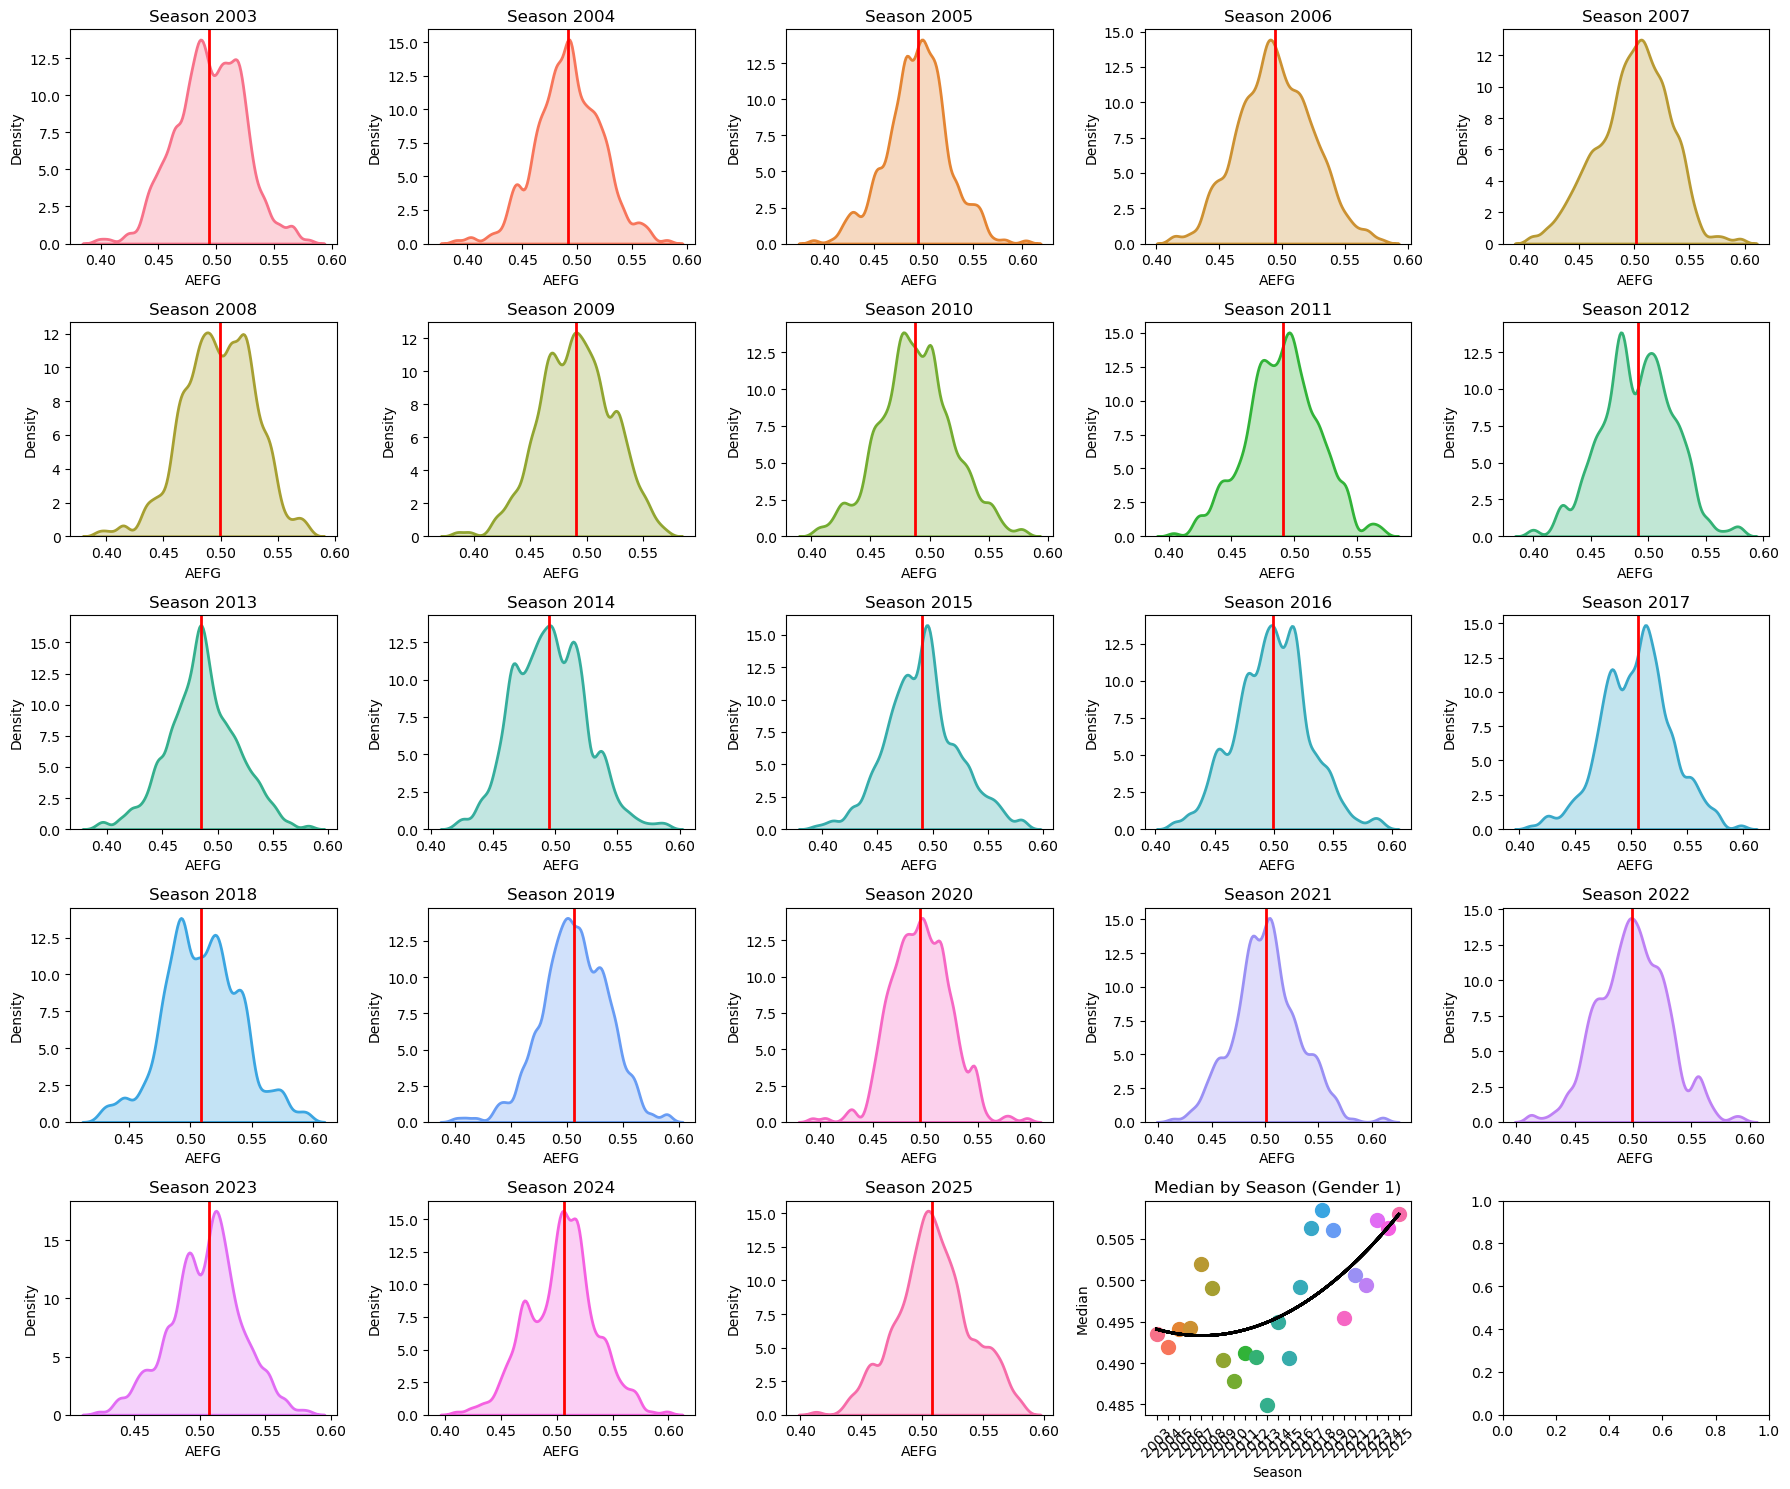

In [9]:
#Some plotting to visualize a feature from the data and how that feature has changed over the seasons... can specify the feature and the gender
column_name = "AEFG"
n_seasons = len(df[df["Gender"] == 1]["Season"].unique())
n_rows = (n_seasons + 4) // 5
palette = sns.color_palette("husl", n_seasons)
season_color = {val: palette[i] for i, val in enumerate(df[df["Gender"] == 1]["Season"].unique())}

fig, axes = plt.subplots(nrows=n_rows, ncols=5, figsize=(18, 3 * n_rows))

for i, (season, data) in enumerate(df[df["Gender"] == 1].groupby("Season")):
    row = i // 5
    col = i % 5
    sns.kdeplot(data=data, x=column_name, fill=True, alpha=0.3, linewidth=2, color=season_color[season], ax=axes[row, col])
    axes[row, col].axvline(data[column_name].median(), color="red", linewidth=2)
    axes[row, col].set_title(f"Season {season}")
    
    # add scatter plot of median
    ax_median = plt.subplot(n_rows, 5, n_seasons + 1)
    ax_median.scatter(season, data[column_name].median(), color=season_color[season], s=100)
    ax_median.set_xlabel("Season")
    ax_median.set_ylabel("Median")
    ax_median.set_xticks(df[df["Gender"] == 1]["Season"].unique())
    ax_median.set_xticklabels(df[df["Gender"] == 1]["Season"].unique(), rotation=45)
    ax_median.set_title("Median by Season (Gender 1)")
    
    # add trendline to median scatter plot
    x = np.array(df[df["Gender"] == 1]["Season"].unique())
    y = np.array([data[column_name].median() for season, data in df[df["Gender"] == 1].groupby("Season")])
    p = np.polyfit(x, y, deg=2)
    f = np.poly1d(p)
    x_new = np.linspace(x[0], x[-1], 100)
    ax_median.plot(x_new, f(x_new), color="black", linewidth=2)
    
fig.tight_layout()
plt.show()

In [33]:
df = df.sort_values(by=["Season"]).reset_index(drop=True)

In [34]:
#Create training and test dataset from the dataframe

train = df

train_x_col = train[['Season', "Set", 'Gender', 'TeamA', 'TeamB', 'AWRatio', 'BWRatio',
       'AEFG', 'BEFG', 'AOppEFG', 'BOppEFG', 'APPP', 'BPPP', 'AOppPPP',
       'BOppPPP', 'ATS', 'BTS', 'AOppTS', 'BOppTS', "AORTG", "BORTG", "ADRTG", "BDRTG",
       'ATOVPct', 'BTOVPct', 'AOppTOV', 'BOppTOV', 'AORPct', 'BORPct',
       'ADRPct', 'BDRPct', 'AFTR', 'BFTR', 'AOppFTR', 'BOppFTR', "4F",
       'SeedA', 'SeedB']]

train_y_col = train["AWin"]

X_train, X_test, y_train, y_test = train_test_split(train_x_col, train_y_col, test_size=0.3, random_state = 0)

In [35]:
#Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [12]:
#Cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [37]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

In [38]:
# Sort by season to ensure chronological split    
#tscv = TimeSeriesSplit(n_splits=5)  # Ensures training on past seasons and testing on future seasons

In [39]:
#I had previously tested other models and this dataframe helped store the scores and importance data
scores = {"XGB": {}, "LGBM": {}, "RF": {}, "KNN": {}, "LR": {}, "SGD": {},
          "Average_Ensemble": {}}
importances = {}

In [ ]:
#XGBoost performed best and was then used for training
#I did not do any hyperparameter tuning
xgb_clf = xgboost.XGBClassifier()
brier = cross_val_score(xgb_clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring='neg_brier_score')
brier = np.mean(brier) * -1
xgb_clf.fit(X_train, y_train)
pred_Y = xgb_clf.predict_proba(X_test)
scores["XGB"]["Brier"] = brier
importances["XGB"] = xgb_clf.feature_importances_

In [41]:
#Create dataframes for both the score dictionary and importance dictionary that I mentioned previously
score_df = pd.DataFrame.from_dict(scores).T
importances_df = pd.DataFrame.from_dict(importances)
importances_df.index = X_train.columns
importances_df['mean_importance'] = importances_df.mean(axis=1)
importances_df = importances_df.sort_values(by='XGB', ascending=False)

In [42]:
#Print above dataframes
print(score_df)
print(importances_df)

                     Brier
XGB               0.168018
LGBM                   NaN
RF                     NaN
KNN                    NaN
LR                     NaN
SGD                    NaN
Average_Ensemble       NaN
              XGB  mean_importance
AWRatio  0.333170         0.333170
BWRatio  0.330228         0.330228
SeedA    0.046832         0.046832
SeedB    0.045850         0.045850
APPP     0.019384         0.019384
BPPP     0.016434         0.016434
TeamB    0.009908         0.009908
TeamA    0.009209         0.009209
AOppTS   0.008756         0.008756
ATOVPct  0.008662         0.008662
BOppTS   0.008367         0.008367
BTOVPct  0.008325         0.008325
AOppPPP  0.008315         0.008315
AOppFTR  0.008276         0.008276
AEFG     0.008207         0.008207
BEFG     0.008159         0.008159
BOppEFG  0.007824         0.007824
AOppEFG  0.007800         0.007800
ADRPct   0.007722         0.007722
BOppPPP  0.007645         0.007645
ATS      0.007576         0.007576
AORPct   0.007

In [ ]:
#0.166202

In [ ]:
#The printed result of the above dataframes... I used this for testing and feature selection
Brier
XGB               0.166202
LGBM                   NaN
RF                     NaN
KNN                    NaN
LR                     NaN
SGD                    NaN
Average_Ensemble       NaN
              XGB  mean_importance
AWRatio  0.332445         0.332445
BWRatio  0.322288         0.322288
SeedB    0.058489         0.058489
SeedA    0.046060         0.046060
BPPP     0.014180         0.014180
APPP     0.012971         0.012971
TeamB    0.009420         0.009420
BOppEFG  0.009320         0.009320
TeamA    0.008953         0.008953
ATOVPct  0.008712         0.008712
AOppTS   0.008625         0.008625
AOppFTR  0.008341         0.008341
AORPct   0.008180         0.008180
BEFG     0.008131         0.008131
BOppTS   0.008118         0.008118
AEFG     0.008116         0.008116
AOppPPP  0.008072         0.008072
BTOVPct  0.008071         0.008071
BOppFTR  0.007869         0.007869
BOppPPP  0.007828         0.007828
Set      0.007775         0.007775
BTS      0.007752         0.007752
AFTR     0.007710         0.007710
BORPct   0.007709         0.007709
ADRPct   0.007623         0.007623
AOppEFG  0.007621         0.007621
ATS      0.007496         0.007496
Season   0.007329         0.007329
BDRPct   0.007310         0.007310
BFTR     0.006967         0.006967
4F       0.006881         0.006881
BOppTOV  0.006837         0.006837
AOppTOV  0.006800         0.006800
BDRTG    0.000000         0.000000
ADRTG    0.000000         0.000000
BORTG    0.000000         0.000000
Gender   0.000000         0.000000
AORTG    0.000000         0.000000

In [18]:
#Load in sample submission and format
sample = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv")
sample['Season'] = sample['ID'].apply(lambda x: int(x.split('_')[0]))
sample['TeamA'] = sample['ID'].apply(lambda x: int(x.split('_')[1]))
sample['TeamB'] = sample['ID'].apply(lambda x: int(x.split('_')[2]))

sample["Season"] = sample.Season.astype("int")
sample["TeamA"] = sample.TeamA.astype("int")
sample["TeamB"] = sample.TeamB.astype("int")

In [19]:
sample

,ID,Pred,Season,TeamA,TeamB
0,2025_1101_1102,0.5,2025,1101,1102
1,2025_1101_1103,0.5,2025,1101,1103
2,2025_1101_1104,0.5,2025,1101,1104
3,2025_1101_1105,0.5,2025,1101,1105
4,2025_1101_1106,0.5,2025,1101,1106
...,...,...,...,...,...
131402,2025_3477_3479,0.5,2025,3477,3479
131403,2025_3477_3480,0.5,2025,3477,3480
131404,2025_3478_3479,0.5,2025,3478,3479
131405,2025_3478_3480,0.5,2025,3478,3480


In [20]:
#Merge sample submission with seed data
sample = sample.merge(men_women_seeds[['Season', 'Seed', 'TeamID']], how='left', left_on=['Season', 'TeamA'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna(0)
sample = sample.merge(men_women_seeds[['Season', 'Seed', 'TeamID']], how='left', left_on=['Season', 'TeamB'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna(0)

In [21]:
#Merge sample dataset with the engineered features
#The data for 2023 is only the regular season... denote this with "0"
sample = pd.merge(sample, df[["Season", "TeamA", "Gender", "AWRatio", "AEFG", "AOppEFG", "APPP", "AOppPPP", "ATS", "AOppTS", "AORTG", "ADRTG", "ATOVPct", "AOppTOV", "AORPct", "ADRPct", "AFTR", "AOppFTR"]].groupby(["Season", "TeamA"]).mean(), on=["Season", "TeamA"], how="left")
sample = pd.merge(sample, df[["Season", "TeamB", "BWRatio", "BEFG", "BOppEFG", "BPPP", "BOppPPP", "BTS", "BOppTS", "BORTG", "BDRTG", "BTOVPct", "BOppTOV", "BORPct", "BDRPct", "BFTR", "BOppFTR"]].groupby(["Season", "TeamB"]).mean(), on=["Season", "TeamB"], how="left")

sample["Set"] = 0
sample[["Gender", "AWRatio", "AEFG", "AOppEFG", "APPP", "AOppPPP", "ATS", "AOppTS", "AORTG", "ADRTG", "ATOVPct", "AOppTOV", "AORPct", "ADRPct", "AFTR", "AOppFTR", "TeamB", "BWRatio", "BEFG", "BOppEFG", "BPPP", "BOppPPP", "BTS", "BOppTS", "BORTG", "BDRTG", "BTOVPct", "BOppTOV", "BORPct", "BDRPct", "BFTR", "BOppFTR"]] = sample[["Gender", "AWRatio", "AEFG", "AOppEFG", "APPP", "AOppPPP", "ATS", "AOppTS", "AORTG", "ADRTG", "ATOVPct", "AOppTOV", "AORPct", "ADRPct", "AFTR", "AOppFTR", "TeamB", "BWRatio", "BEFG", "BOppEFG", "BPPP", "BOppPPP", "BTS", "BOppTS", "BORTG", "BDRTG", "BTOVPct", "BOppTOV", "BORPct", "BDRPct", "BFTR", "BOppFTR"]].fillna(sample[["Gender", "AWRatio", "AEFG", "AOppEFG", "APPP", "AOppPPP", "ATS", "AOppTS", "AORTG", "ADRTG", "ATOVPct", "AOppTOV", "AORPct", "ADRPct", "AFTR", "AOppFTR", "TeamB", "BWRatio", "BEFG", "BOppEFG", "BPPP", "BOppPPP", "BTS", "BOppTS", "BORTG", "BDRTG", "BTOVPct", "BOppTOV", "BORPct", "BDRPct", "BFTR", "BOppFTR"]].mean())

In [22]:
#Engineer the last feature and select the features for predictions
sample[["Season", "TeamB", "TeamA", "SeedA", "SeedB", "Gender", "Set"]] = sample[["Season", "TeamB", "TeamA", "SeedA", "SeedB", "Gender", "Set"]].astype(int)
sample["4fODiff"] = (0.4 * (sample["AEFG"] - sample["BEFG"])) - (0.25 * (sample["ATOVPct"] - sample["BTOVPct"])) + (0.2 * (sample["AORPct"] - sample["BORPct"])) + (0.15 * (sample["AFTR"] - sample["BFTR"]))
sample["4fDDiff"] = -(0.4 * (sample["AOppEFG"] - sample["BOppEFG"])) + (0.25 * (sample["AOppTOV"] - sample["BOppTOV"])) + (0.2 * (sample["ADRPct"] - sample["BDRPct"])) - (0.15 * (sample["AOppFTR"] - sample["BOppFTR"]))
sample["4F"] = sample["4fODiff"] - sample["4fDDiff"]
sample.drop(["4fODiff", "4fDDiff"], axis=1, inplace=True)
sample = sample[['Season', "Set", 'Gender', 'TeamA', 'TeamB', 'AWRatio', 'BWRatio',
       'AEFG', 'BEFG', 'AOppEFG', 'BOppEFG', 'APPP', 'BPPP', 'AOppPPP',
       'BOppPPP', 'ATS', 'BTS', 'AOppTS', 'BOppTS', 'AORTG', 'BORTG', 'ADRTG',
       'BDRTG', 'ATOVPct', 'BTOVPct', 'AOppTOV', 'BOppTOV', 'AORPct', 'BORPct',
       'ADRPct', 'BDRPct', 'AFTR', 'BFTR', 'AOppFTR', 'BOppFTR', "4F",
       'SeedA', 'SeedB']]

In [23]:
#Scale sample data
sample = pd.DataFrame(scaler.transform(sample), columns=sample.columns, index=sample.index)

In [24]:
#Predict on submission set and prepare submission for the competition
sample_final = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv")
sub_pred = xgb_clf.predict_proba(sample).astype(float)
sub_pred = sub_pred[:, 1]
sample_final['Pred'] = sub_pred
sample_final.to_csv("xgb1.csv", index = False)

In [28]:
sample_final[sample_final['Pred'] > 0.99]

,ID,Pred
769,2025_1103_1154,0.990514
902,2025_1103_1290,0.992659
1086,2025_1104_1105,0.991451
1095,2025_1104_1115,0.991887
1129,2025_1104_1154,0.996516
...,...,...
131026,2025_3452_3478,0.997829
131027,2025_3452_3479,0.994299
131037,2025_3453_3462,0.990459
131038,2025_3453_3463,0.993386


In [ ]:
# do hyperparameter tuning
# split for two models W and M
# change CV